In [2]:
%load_ext autoreload
%autoreload 2

In [35]:
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.colors import ListedColormap
import webcolors
from PIL import Image, ImageDraw

import networkx as nx

from minimal.imaging import blit_rooms, draw_sep_nask_wireframe
from minimal.layout import LayoutGraph, NodeType, NODE_COLOR
from minimal.gen import PlanMasks
from minimal.rooms import RoomAreas, extract_rooms, scale_room_mask
from minimal.walls import scale_sep_mask, _conv_mask
from minimal.walls import (
    CC_TL,
    CC_TR,
    CC_BR,
    CC_BL,
    CC_T,
    CC_R,
    CC_B,
    CC_L
)
from minimal.doors import extract_face_walls, candidate_wall_runs
from reflow.common import conv_mask

%matplotlib inline

In [4]:
cmapr = ListedColormap(['white', *plt.get_cmap('tab10').colors])
cmapw = ListedColormap(['white', 'black', *plt.get_cmap('tab10').colors])

In [5]:
%%time
pm = PlanMasks.create_from_state(torch.load("data/plan_masks_05.pth"))

CPU times: user 800 µs, sys: 0 ns, total: 800 µs
Wall time: 692 µs


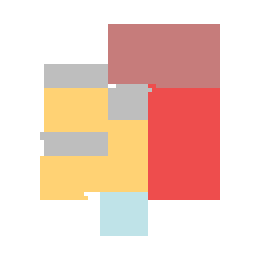

<PlanMasks 125566485442080>

In [32]:
pm

In [10]:
def calc_min_area(scale: tuple[int, int]):
    return 4

InputGraph = LayoutGraph
RectGraph = RoomAreas

In [12]:
input_graph = pm.graph
scale = (3, 3)

In [25]:
segmentation_masks = [pm.masks[i] for i in range(pm.masks.shape[0]) if NodeType.is_room(pm.graph.nodes[i])]
node_types = [pm.graph.nodes[i] for i in range(pm.masks.shape[0]) if NodeType.is_room(pm.graph.nodes[i])]
R = len(segmentation_masks)

In [28]:
min_area_units = calc_min_area(scale)

rect_graphs = []
for i in range(R):
    room_type = node_types[i]
    room_sgm_mask = segmentation_masks[i]

    graph = RectGraph(room_type, i, room_sgm_mask)

    # Remove short rectangles
    #
    # TODO: maybe keep rectangles with degree >= 2 as they
    #       will prove to be a "pathway" between multiple
    #       (potentially) disconnected rooms
    # TODO: store the removed rects ("bad" rects) to maybe
    #       salvage them later on
    graph.threshold_rectangles(min_area_units)

    # Keep the largest connected component (by total area)
    # 
    # TODO: store the removed rects ("bad" rects) to maybe
    #       salvage them later on
    graph.discard_small_components()

    rect_graphs.append(graph)

rect_graphs.sort(key=lambda g: g.total_area())

In [30]:
room_masks = [] # room_mask(r): 1 = yes r / 0 = no r
for graph in rect_graphs:
    room_masks.append(graph.to_mask())

In [187]:
CC_TL = 0b00000001  # Top left corner
CC_TR = 0b00000010  # Top right corner
CC_BR = 0b00000100  # Bottom right corner
CC_BL = 0b00001000  # Bottom left corner

CC_T  = 0b00010000  # Top edge
CC_R  = 0b00100000  # Right edge
CC_B  = 0b01000000  # Bottom edge
CC_L  = 0b10000000  # Left edge

_sep_kernel = torch.tensor([
    [CC_TL,  CC_T, CC_TR],
    [CC_L ,     0,  CC_R],
    [CC_BL,  CC_B, CC_BR],
], dtype=torch.int8)

def create_sep_mask(room_masks: list):
    col_mask = torch.ones_like(room_masks[0])
    sep_mask = torch.zeros_like(room_masks[0])

    for rmask in reversed(room_masks):
        col_mask *= (1 - rmask)
        sep_mask += rmask * conv_mask(col_mask, _sep_kernel)

    return sep_mask

CPU times: user 53.3 ms, sys: 1.05 ms, total: 54.4 ms
Wall time: 43.9 ms


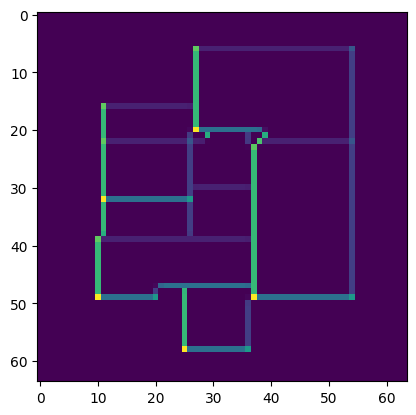

In [192]:
%%time
sep_mask = create_sep_mask(room_masks)
plt.imshow(sep_mask)